In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from SSN_flexible_size import *

sns.set_style('white')

In [2]:
%matplotlib notebook

In [3]:
sigma=30.
sigma_broad=100.
sigma_vip=30.
sigma_in=30
stim_ori=0
spont_input=[2,2,2,10]
run_input=[0,0,0,0]
# calc_freq=np.arange(.0000001, .02, .000001)
# calc_freq = np.linspace(0, .02, 41)
calc_freq = [0]
k=.04
n_power=2.
savepath='figs/'
savename='pp_proj_width'

In [4]:
print(connection_weights())

[[ 0.037  -0.037  -0.0555 -0.    ]
 [ 0.148  -0.0185 -0.0185  0.    ]
 [ 0.222   0.      0.     -0.0037]
 [ 0.111  -0.     -0.037   0.    ]]


In [4]:
W = connection_weights()
print(W[0, 1] / (W[0, 1] + W[0, 2]))

0.39999999999999997


In [6]:
input_strengths = np.linspace(0, 100, 101)
# input_strengths = np.arange(0, 30)
weight_scaling = np.linspace(0, 1, 101)
# width_ratios=np.linspace(.1, 5, 6)

W = connection_weights()
net = init_net()

N1 = len(input_strengths)
N2 = len(weight_scaling)
Nfreq = len(calc_freq)

max_eig = np.zeros((N1, N2))
max_eig_freq = np.zeros((N1, N2))
rate_plot = np.zeros((N1, N2)) * np.nan
rate_plot_pv = np.zeros((N1, N2)) * np.nan
rate_plot_sst = np.zeros((N1, N2)) * np.nan
rate_plot_vip = np.zeros((N1, N2)) * np.nan

isn_plot = np.zeros((N1, N2, Nfreq)) * np.nan

ext_input = get_input_matrix(net,sigma_in,stim_ori=stim_ori)

# for i_proj_width, width_ratio in enumerate(width_ratios):
#     print('projection width ratio: '+str(width_ratio))
#     sigma = 30. * width_ratio

Wei_tot = W[0, 1] + W[0, 2]
W_e_pv_default = W[0, 1].copy()
W_e_sst_default = W[0, 2].copy()

for i_proj_width, weight_scale in enumerate(weight_scaling):
    
    print(i_proj_width)
    W = connection_weights()
    W[0, 1] = Wei_tot * weight_scale
    W[0, 2] = Wei_tot * (1. - weight_scale)
#     W[0, 1:] = wE_default * EE_scale
    
    rates_over_inputs = []
    
    for i_input, input_strength in enumerate(input_strengths):
        # print('input: ' + str(input_strength))

        # calculate total input to all of the neurons
        eff_input = multiply_inputs(ext_input,[input_strength,input_strength,0,0])
        eff_input = add_inputs(eff_input,spont_input)
        eff_input = add_inputs(eff_input,run_input)

        # solve for steady state
        if i_input>0:
            r, net_inputs = euler_flexible_size(net,
                                   W,
                                   eff_input,
                                   init_rates=rates_over_inputs[-1],
                                   gain=k,
                                   power=n_power,
                                   tstop=10000,
                                   sigma=sigma,
                                   sigma_vip=sigma_vip,
                                   sigma_broad=sigma_broad,
                                   return_total_input=True)
        else:
            r, net_inputs = euler_flexible_size(net,
                                   W,
                                   eff_input,
                                   gain=k,
                                   power=n_power,
                                   tstop=10000,
                                   sigma=sigma,
                                   sigma_vip=sigma_vip,
                                   sigma_broad=sigma_broad,
                                   return_total_input=True)

        rates_over_inputs.append(r)

        rate_plot[i_input, i_proj_width] = r[0][0] # cux2 at 0 deg
        rate_plot_pv[i_input, i_proj_width] = r[1][0] # pv at 0 deg
        rate_plot_sst[i_input, i_proj_width] = r[2][0] # cux2 at 0 deg
        rate_plot_vip[i_input, i_proj_width] = r[3][0] # cux2 at 0 deg

        if np.any(r[0] > 1000) or np.any(r[1] > 1000) or np.any(r[2] > 1000) or np.any(r[3] > 1000):
            rate_plot[i_input, i_proj_width] = np.nan
            rate_plot_pv[i_input, i_proj_width] = np.nan
            rate_plot_sst[i_input, i_proj_width] = np.nan
            rate_plot_vip[i_input, i_proj_width] = np.nan
            break
        elif np.any(~np.isfinite(r[0])) or np.any(~np.isfinite(r[1])) or np.any(~np.isfinite(r[2])) or np.any(~np.isfinite(r[3])):
            rate_plot[i_input, i_proj_width] = np.nan
            rate_plot_pv[i_input, i_proj_width] = np.nan
            rate_plot_sst[i_input, i_proj_width] = np.nan
            rate_plot_vip[i_input, i_proj_width] = np.nan
            break
        else:
            pass
        
        max_eig_ii, is_isn_ii = linear_stability(net_inputs, W, calc_freq=calc_freq, sigma_ee=sigma, sigma_vipe=sigma_vip, sigma_broad=sigma_broad)
        isn_plot[i_input, i_proj_width] = is_isn_ii

0


/Users/gabeo/Documents/projects/contrast_analysis/SSN_flexible_size.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  is_isn[i] = Wf[0, 0]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [9]:
### save the outputs
datapath = 'data/'
np.save(datapath+'rate_cux2_over_input_and_pv_frac.npy', rate_plot)
np.save(datapath+'rate_pv_over_input_and_pv_frac.npy', rate_plot_pv)
np.save(datapath+'rate_sst_over_input_and_pv_frac.npy', rate_plot_sst)
np.save(datapath+'rate_vip_over_input_and_pv_frac.npy', rate_plot_vip)
np.save(datapath+'ee_stability_over_input_and_pv_frac.npy', np.amax(isn_plot, axis=-1))

np.save(datapath+'pv_frac.npy', weight_scaling)
np.save(datapath+'input_strengths.npy', input_strengths)

<IPython.core.display.Javascript object>


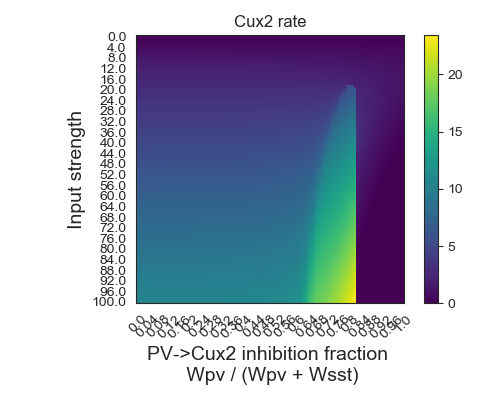

<IPython.core.display.Javascript object>


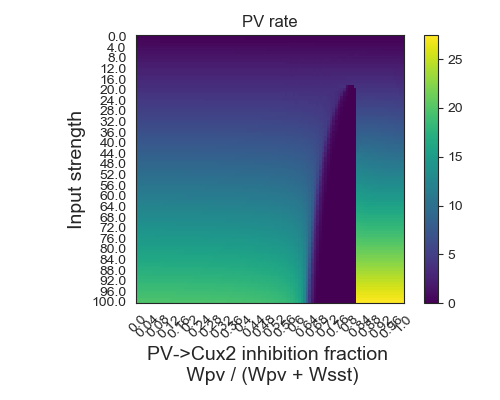

<IPython.core.display.Javascript object>


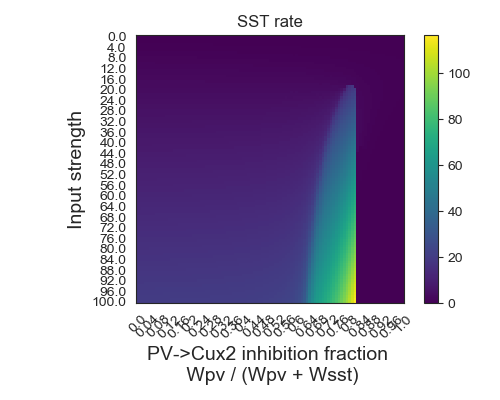

<IPython.core.display.Javascript object>


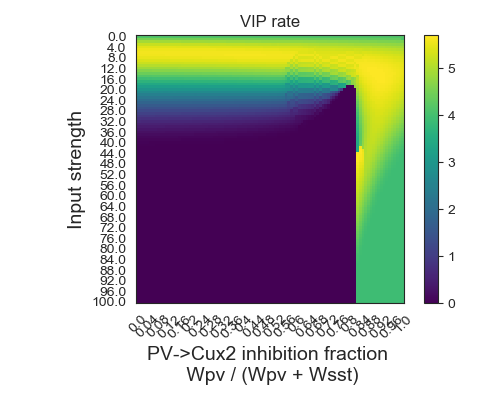

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('Cux2 rate')
ax.set_xlabel('PV->Cux2 inhibition fraction \n Wpv / (Wpv + Wsst)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_cux2_over_input_and_pv_frac.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot_pv, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('PV rate')
ax.set_xlabel('PV->Cux2 inhibition fraction \n Wpv / (Wpv + Wsst)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_pv_over_input_and_pv_frac.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot_sst, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('SST rate')
ax.set_xlabel('PV->Cux2 inhibition fraction \n Wpv / (Wpv + Wsst)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_sst_over_input_and_pv_frac.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot_vip, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('VIP rate')
ax.set_xlabel('PV->Cux2 inhibition fraction \n Wpv / (Wpv + Wsst)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_vip_over_input_and_pv_frac.png')

In [10]:
print(np.amax(isn_plot, axis=-1))

[[0.03921678 0.0391501  0.03908297 ... 0.03625993 0.03616461 0.03606896]
 [0.18334796 0.18272183 0.18207661 ... 0.1404384  0.13870789 0.13695291]
 [0.24365848 0.24387263 0.24398902 ... 0.19855684 0.19565814 0.19271184]
 ...
 [0.8371108  0.83935404 0.84183963 ... 0.                nan 0.13404665]
 [0.84625486 0.8484532  0.85107619 ... 0.                nan 0.10887135]
 [0.8550301  0.85774744 0.85984553 ... 0.                nan 0.08239384]]


1.6663001934389914


<IPython.core.display.Javascript object>


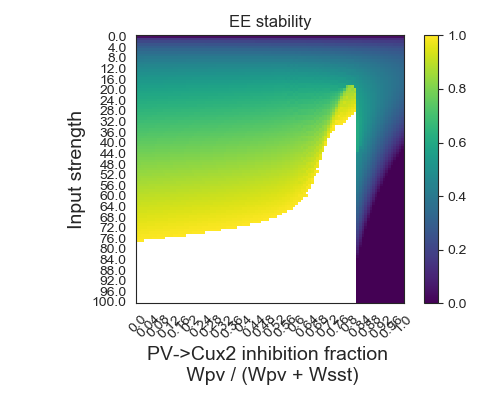

In [11]:
pp_isn = np.amax(isn_plot, axis=-1)
print(np.amax(pp_isn))

for i in range(pp_isn.shape[0]):
    
    pp_isn_i = pp_isn[i].copy()
    ind = np.where(pp_isn_i >= 1.)[0]
    pp_isn[i, ind] = np.nan
    

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(pp_isn, vmin=0, vmax=1, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('EE stability')
ax.set_xlabel('PV->Cux2 inhibition fraction \n Wpv / (Wpv + Wsst)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'isn_over_input_and_pv_frac.png')

### let's vary the relative projection width of the narrow (cux2->cux2 & vip) and broad excitatory projections

In [12]:
input_strengths = np.linspace(0, 100, 101)
# input_strengths = np.arange(0, 30)
# weight_scaling = np.linspace(0, 1, 41)
width_ratios=np.linspace(.1, 1, 101)

W = connection_weights()
net = init_net()

N1 = len(input_strengths)
N2 = len(width_ratios)
Nfreq = len(calc_freq)

max_eig = np.zeros((N1, N2))
max_eig_freq = np.zeros((N1, N2))
phase_plot = np.zeros((N1, N2)) * np.nan
phase_plot_pv = np.zeros((N1, N2)) * np.nan
phase_plot_sst = np.zeros((N1, N2)) * np.nan
phase_plot_vip = np.zeros((N1, N2)) * np.nan
isn_plot = np.zeros((N1, N2, Nfreq)) * np.nan

rates = []
ext_input = get_input_matrix(net,sigma_in,stim_ori=stim_ori)

# for i_proj_width, width_ratio in enumerate(width_ratios):
#     print('projection width ratio: '+str(width_ratio))
#     sigma = 30. * width_ratio

sigma=30.
sigma_broad=100.
sigma_vip=30.
sigma_in=30

for i_proj_width, width in enumerate(width_ratios):
    
    print(i_proj_width)
    W = connection_weights()

    sigma = sigma_broad * width
    sigma_vip = sigma_broad * width
    
    rates_over_inputs = []
    
    for i_input, input_strength in enumerate(input_strengths):
        # print('input: ' + str(input_strength))

        # calculate total input to all of the neurons
        eff_input = multiply_inputs(ext_input,[input_strength,input_strength,0,0])
        eff_input = add_inputs(eff_input,spont_input)
        eff_input = add_inputs(eff_input,run_input)

        # solve for steady state
        if i_input>0:
            r, net_inputs = euler_flexible_size(net,
                                   W,
                                   eff_input,
                                   init_rates=rates_over_inputs[-1],
                                   gain=k,
                                   power=n_power,
                                   tstop=10000,
                                   sigma=sigma,
                                   sigma_vip=sigma_vip,
                                   sigma_broad=sigma_broad,
                                   return_total_input=True)
        else:
            r, net_inputs = euler_flexible_size(net,
                                   W,
                                   eff_input,
                                   gain=k,
                                   power=n_power,
                                   tstop=10000,
                                   sigma=sigma,
                                   sigma_vip=sigma_vip,
                                   sigma_broad=sigma_broad,
                                   return_total_input=True)

        rates_over_inputs.append(r)

        phase_plot[i_input, i_proj_width] = r[0][0] # cux2 at 0 deg
        phase_plot_pv[i_input, i_proj_width] = r[1][0] # pv at 0 deg
        phase_plot_sst[i_input, i_proj_width] = r[2][0] # cux2 at 0 deg
        phase_plot_vip[i_input, i_proj_width] = r[3][0] # cux2 at 0 deg

        if np.any(r[0] > 1000) or np.any(r[1] > 1000) or np.any(r[2] > 1000) or np.any(r[3] > 1000):
            phase_plot[i_input, i_proj_width] = np.nan
            phase_plot_pv[i_input, i_proj_width] = np.nan
            phase_plot_sst[i_input, i_proj_width] = np.nan
            phase_plot_vip[i_input, i_proj_width] = np.nan
            break
        elif np.any(~np.isfinite(r[0])) or np.any(~np.isfinite(r[1])) or np.any(~np.isfinite(r[2])) or np.any(~np.isfinite(r[3])):
            phase_plot[i_input, i_proj_width] = np.nan
            phase_plot_pv[i_input, i_proj_width] = np.nan
            phase_plot_sst[i_input, i_proj_width] = np.nan
            phase_plot_vip[i_input, i_proj_width] = np.nan
            break
        else:
            pass

        max_eig_ii, is_isn_ii = linear_stability(net_inputs, W, calc_freq=calc_freq, sigma_ee=sigma, sigma_vipe=sigma_vip, sigma_broad=sigma_broad)
        isn_plot[i_input, i_proj_width] = is_isn_ii

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [13]:
datapath = 'data/'
np.save(datapath+'rate_cux2_over_input_and_proj_widths.npy', rate_plot)
np.save(datapath+'rate_pv_over_input_and_proj_widths.npy', rate_plot_pv)
np.save(datapath+'rate_sst_over_input_and_proj_widths.npy', rate_plot_sst)
np.save(datapath+'rate_vip_over_input_and_proj_widths.npy', rate_plot_vip)
np.save(datapath+'ee_stability_over_input_and_proj_widths.npy', np.amax(isn_plot, axis=-1))

np.save(datapath+'proj_widths.npy', width_ratios)
# np.save(input_strengths, datapth+'input_strengths.npy')

<IPython.core.display.Javascript object>


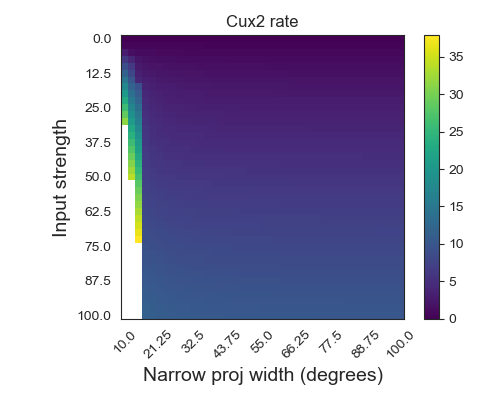

<IPython.core.display.Javascript object>


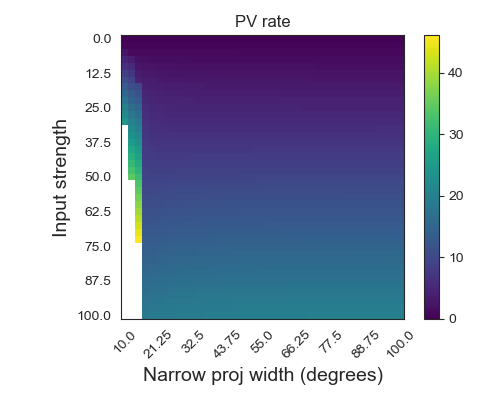

<IPython.core.display.Javascript object>


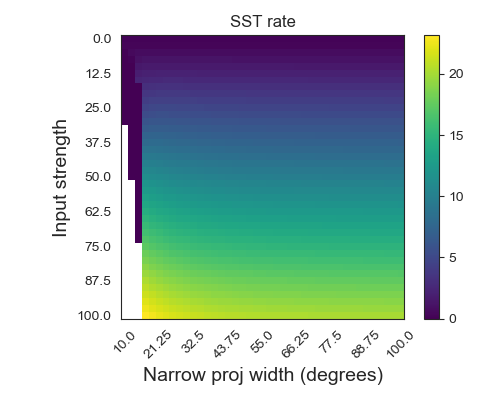

<IPython.core.display.Javascript object>


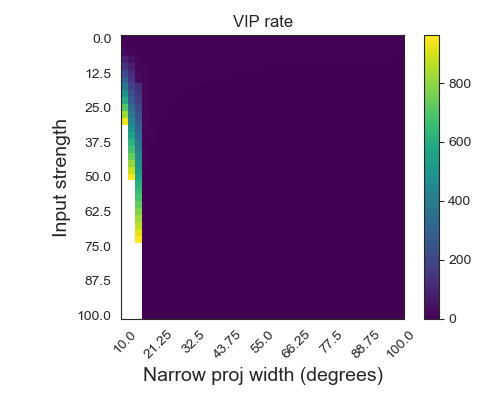

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(phase_plot, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('Cux2 rate')
ax.set_xlabel('Narrow proj width (degrees)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(width_ratios))[::5])
ax.set_xticklabels(np.round(width_ratios[::5]*100, 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::5])
ax.set_yticklabels(input_strengths[::5])

fig.tight_layout()
fig.savefig(savepath+'rate_cux2_over_input_and_proj_widths.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(phase_plot_pv, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('PV rate')
ax.set_xlabel('Narrow proj width (degrees)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(width_ratios))[::5])
ax.set_xticklabels(np.round(width_ratios[::5]*100, 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::5])
ax.set_yticklabels(input_strengths[::5])

fig.tight_layout()
fig.savefig(savepath+'rate_pv_over_input_and_proj_widths.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(phase_plot_sst, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('SST rate')
ax.set_xlabel('Narrow proj width (degrees)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(width_ratios))[::5])
ax.set_xticklabels(np.round(width_ratios[::5]*100, 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::5])
ax.set_yticklabels(input_strengths[::5])

fig.tight_layout()
fig.savefig(savepath+'rate_sst_over_input_and_proj_widths.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(phase_plot_vip, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('VIP rate')
ax.set_xlabel('Narrow proj width (degrees)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(width_ratios))[::5])
ax.set_xticklabels(np.round(width_ratios[::5]*100, 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::5])
ax.set_yticklabels(input_strengths[::5])

fig.tight_layout()
fig.savefig(savepath+'rate_vip_over_input_and_proj_widths.png')

nan


/Users/gabeo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


<IPython.core.display.Javascript object>


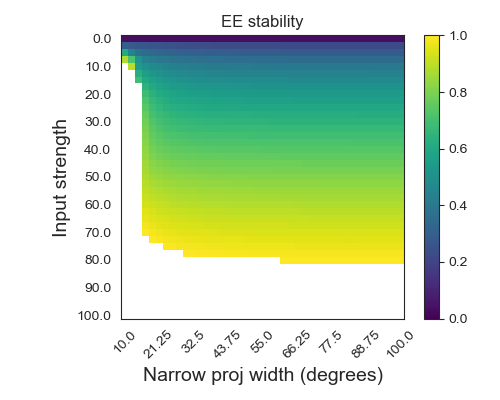

In [12]:
pp_isn = np.amax(isn_plot, axis=-1)
print(np.amax(pp_isn))

for i in range(pp_isn.shape[0]):
    
    pp_isn_i = pp_isn[i].copy()
    ind = np.where(pp_isn_i >= 1.)[0]
    pp_isn[i, ind] = np.nan
    

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(pp_isn, vmin=0, vmax=1, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('EE stability')
ax.set_xlabel('Narrow proj width (degrees)', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(width_ratios))[::5])
ax.set_xticklabels(np.round(width_ratios[::5]*100, 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'isn_over_input_and_proj_widths.png')

### let's vary the strength of vip->sst projections

In [15]:
sigma=30.
sigma_broad=100.
sigma_vip=30.
sigma_in=30
stim_ori=0
spont_input=[2,2,2,10]
run_input=[0,0,0,0]
# calc_freq=np.arange(.0000001, .02, .000001)
# calc_freq = np.linspace(0, .02, 41)
calc_freq = [0]
k=.04
n_power=2.

In [16]:
W = connection_weights()
print(W)

[[ 0.037  -0.037  -0.0555 -0.    ]
 [ 0.148  -0.0185 -0.0185  0.    ]
 [ 0.222   0.      0.     -0.0037]
 [ 0.111  -0.     -0.037   0.    ]]


In [ ]:
input_strengths = np.linspace(0, 100, 101)
weight_scaling = np.linspace(0, 5, 101)
# width_ratios=np.linspace(.1, 5, 6)

W = connection_weights()
net = init_net()

N1 = len(input_strengths)
N2 = len(weight_scaling)
Nfreq = len(calc_freq)

max_eig = np.zeros((N1, N2))
max_eig_freq = np.zeros((N1, N2))
rate_plot = np.zeros((N1, N2)) * np.nan
rate_plot_pv = np.zeros((N1, N2)) * np.nan
rate_plot_sst = np.zeros((N1, N2)) * np.nan
rate_plot_vip = np.zeros((N1, N2)) * np.nan

isn_plot = np.zeros((N1, N2, Nfreq)) * np.nan

ext_input = get_input_matrix(net,sigma_in,stim_ori=stim_ori)

# for i_proj_width, width_ratio in enumerate(width_ratios):
#     print('projection width ratio: '+str(width_ratio))
#     sigma = 30. * width_ratio

Wvip_default = W[2, 3].copy()

for i_proj_width, weight_scale in enumerate(weight_scaling):
    
    print(i_proj_width)
    W = connection_weights()
    W[2, 3] = Wvip_default * weight_scale

    rates_over_inputs = []
    
    for i_input, input_strength in enumerate(input_strengths):
        # print('input: ' + str(input_strength))

        # calculate total input to all of the neurons
        eff_input = multiply_inputs(ext_input,[input_strength,input_strength,0,0])
        eff_input = add_inputs(eff_input,spont_input)
        eff_input = add_inputs(eff_input,run_input)

        # solve for steady state
        if i_input>0:
            r, net_inputs = euler_flexible_size(net,
                                   W,
                                   eff_input,
                                   init_rates=rates_over_inputs[-1],
                                   gain=k,
                                   power=n_power,
                                   tstop=10000,
                                   sigma=sigma,
                                   sigma_vip=sigma_vip,
                                   sigma_broad=sigma_broad,
                                   return_total_input=True)
        else:
            r, net_inputs = euler_flexible_size(net,
                                   W,
                                   eff_input,
                                   gain=k,
                                   power=n_power,
                                   tstop=10000,
                                   sigma=sigma,
                                   sigma_vip=sigma_vip,
                                   sigma_broad=sigma_broad,
                                   return_total_input=True)

        rates_over_inputs.append(r)

        rate_plot[i_input, i_proj_width] = r[0][0] # cux2 at 0 deg
        rate_plot_pv[i_input, i_proj_width] = r[1][0] # pv at 0 deg
        rate_plot_sst[i_input, i_proj_width] = r[2][0] # sst at 0 deg
        rate_plot_vip[i_input, i_proj_width] = r[3][0] # vip at 0 deg

        if np.any(r[0] > 1000) or np.any(r[1] > 1000) or np.any(r[2] > 1000) or np.any(r[3] > 1000):
            rate_plot[i_input, i_proj_width] = np.nan
            rate_plot_pv[i_input, i_proj_width] = np.nan
            rate_plot_sst[i_input, i_proj_width] = np.nan
            rate_plot_vip[i_input, i_proj_width] = np.nan
            break
        elif np.any(~np.isfinite(r[0])) or np.any(~np.isfinite(r[1])) or np.any(~np.isfinite(r[2])) or np.any(~np.isfinite(r[3])):
            rate_plot[i_input, i_proj_width] = np.nan
            rate_plot_pv[i_input, i_proj_width] = np.nan
            rate_plot_sst[i_input, i_proj_width] = np.nan
            rate_plot_vip[i_input, i_proj_width] = np.nan
            break
        else:
            pass
        
        max_eig_ii, is_isn_ii = linear_stability(net_inputs, W, calc_freq=calc_freq, sigma_ee=sigma, sigma_vipe=sigma_vip, sigma_broad=sigma_broad)
        isn_plot[i_input, i_proj_width] = is_isn_ii

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [ ]:
datapath = 'data/'
np.save(datapath+'rate_cux2_over_input_and_vipsst.npy', rate_plot)
np.save(datapath+'rate_pv_over_input_and_vipsst.npy', rate_plot_pv)
np.save(datapath+'rate_sst_over_input_and_vipsst.npy', rate_plot_sst)
np.save(datapath+'rate_vip_over_input_and_vipsst.npy', rate_plot_vip)
np.save(datapath+'ee_stability_over_input_and_vipsst.npy', np.amax(isn_plot, axis=-1))

np.save(datapath+'weight_scaling_vipsst.npy', weight_scaling)

In [7]:
savepath='figs/'

<IPython.core.display.Javascript object>


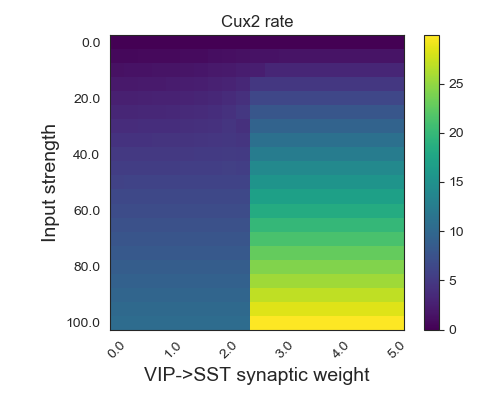

<IPython.core.display.Javascript object>


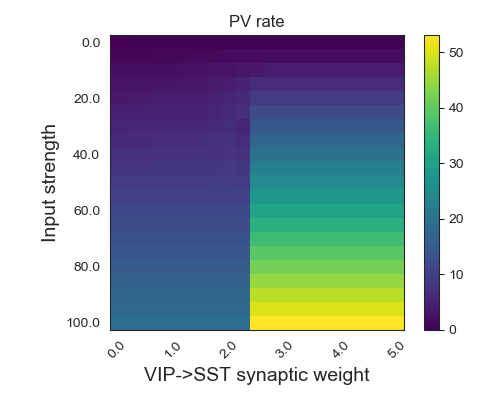

<IPython.core.display.Javascript object>


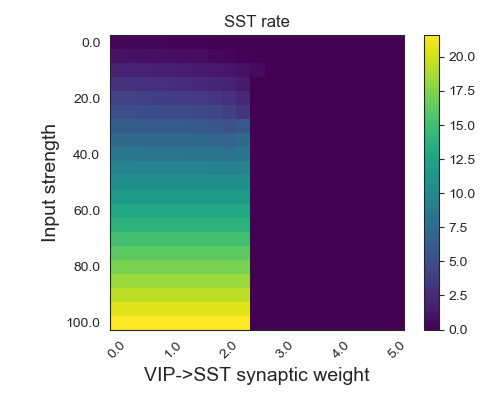

<IPython.core.display.Javascript object>


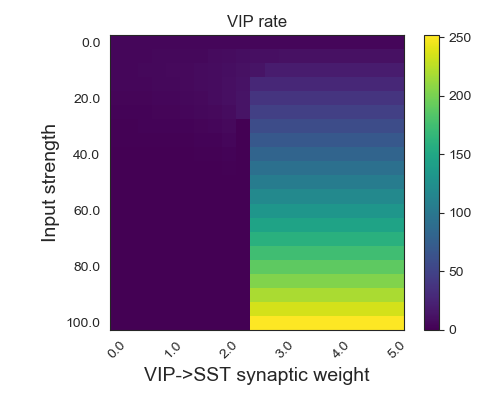

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('Cux2 rate')
ax.set_xlabel('VIP->SST synaptic weight', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_cux2_over_input_and_vipsst.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot_pv, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('PV rate')
ax.set_xlabel('VIP->SST synaptic weight', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_pv_over_input_and_vipsst.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot_sst, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('SST rate')
ax.set_xlabel('VIP->SST synaptic weight', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_sst_over_input_and_vipsst.png')


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(rate_plot_vip, vmin=0, vmax=None, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('VIP rate')
ax.set_xlabel('VIP->SST synaptic weight', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'rate_vip_over_input_and_vipsst.png')

1.937026891439187


<IPython.core.display.Javascript object>


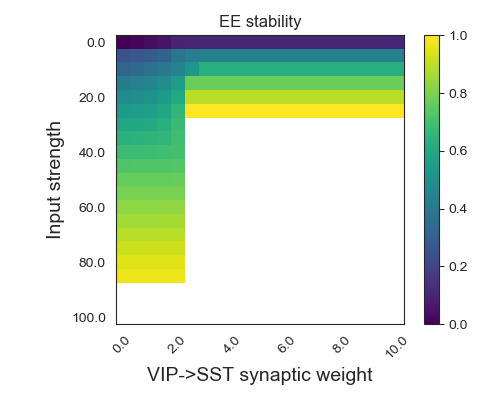

In [9]:
pp_isn = np.amax(isn_plot, axis=-1)
print(np.amax(pp_isn))

for i in range(pp_isn.shape[0]):
    
    pp_isn_i = pp_isn[i].copy()
    ind = np.where(pp_isn_i >= 1.)[0]
    pp_isn[i, ind] = np.nan
    

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(pp_isn, vmin=0, vmax=1, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('EE stability')
ax.set_xlabel('VIP->SST synaptic weight', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()
fig.savefig(savepath+'isn_over_input_and_vipsst.png')

<IPython.core.display.Javascript object>


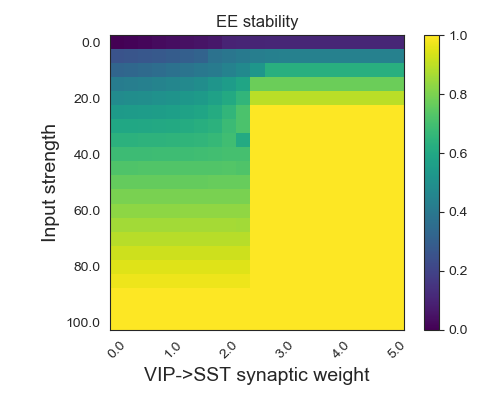

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(isn_plot[:, :, 0], vmin=0, vmax=1, cmap='viridis')
plt.colorbar(im, ax=ax)

ax.set_title('EE stability')
ax.set_xlabel('VIP->SST synaptic weight', fontsize=14)
# ax[1].set_xlabel('Projection width ratio: Pyr->VIP / Pyr->Pyr', fontsize=14)
ax.set_ylabel('Input strength', fontsize=14)
# ax.set_xticks(EE_scaling)
ax.set_xticks(range(len(weight_scaling))[::4])
ax.set_xticklabels(np.round(weight_scaling[::4], 2), rotation=45)

ax.set_yticks(range(len(input_strengths))[::4])
ax.set_yticklabels(input_strengths[::4])

fig.tight_layout()